### Outline
1. Using torchvision.datasets with a custom folder of images
2. Occlusion analysis with pretrained model
3. Filter visualisation with pretrained model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models 
import torchvision.transforms as transforms

### Load dataset

In [3]:
with open("../input/imagenett/data/imagenet_labels.txt") as f:
    classes = eval(f.read())

In [4]:
# print(classes)

In [5]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [6]:
evalset = torchvision.datasets.ImageFolder(root = '../input/imagenett/data/imagenet', transform=transform)

In [7]:
batch_size = 1

In [8]:
evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle=True)

In [9]:
dataiter = iter(evalloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


### Load pretrained model

In [10]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [11]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Visualise Image

In [12]:
def imshow(img, title):
    
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(),std_correction) + mean_correction
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [13]:
def show_batch_images(dataloader):
    images, _ = next(iter(dataloader))
    
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[classes[x.item()] for x in pred])
    
    return images, pred

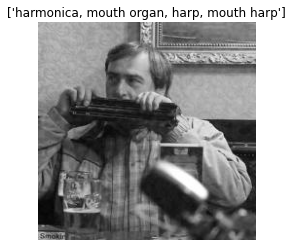

In [14]:
images, pred = show_batch_images(evalloader)

### Occlusion Analysis

In [15]:
outputs = model(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, 1)
prob_no_occ = prob_no_occ[0].item()
print(prob_no_occ)

torch.Size([1, 1000])
0.8043234944343567


In [16]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
    
    width, height = image.shape[-2], image.shape[-1]
    
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    
    heatmap = torch.zeros((output_height, output_width))
    
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
                
            input_image = image.clone().detach()
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            heatmap[h, w] = prob
            
    return heatmap

In [17]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)

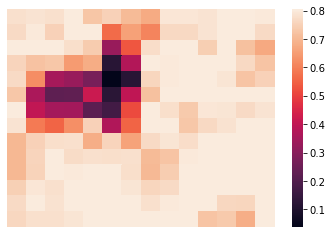

In [18]:
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax = prob_no_occ)

### Filter Visalisation

In [19]:
alexnet = models.alexnet(pretrained = True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [20]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
def plot_filters_single_channel_big(t):
    
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
          
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [22]:
def plot_filters_single_channel(t):
    
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols
    
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [23]:
def plot_filters_multi_channel(t):
    
    num_kernels = t.shape[0]    
    
    num_cols = 12
    num_rows = num_kernels
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        npimg = np.array(t[i].numpy(), np.float32)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [24]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
    
    layer = model.features[layer_num]
    if isinstance(layer, nn.Conv2d):
        weight_tensor = model.features[layer_num].weight.data
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                'Can only plot weights with three channels with single_channel = False'
    else:
        print('Can only visualise layers which are convolutional')

In [25]:
# plot_weights(alexnet, 0, single_channel = False)

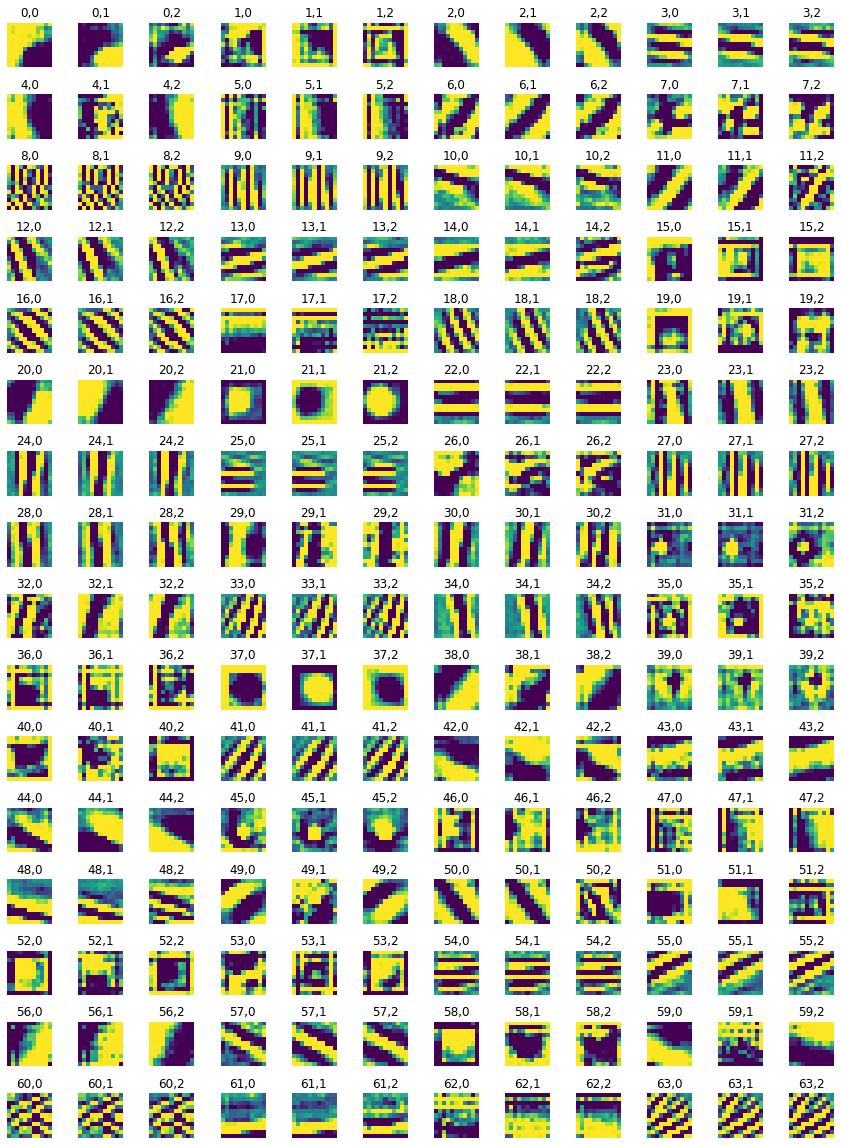

In [26]:
plot_weights(alexnet, 0, single_channel = True)

In [27]:
plot_weights(alexnet, 3, single_channel = True)

ValueError: Image size of 864x73800 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 864x73800 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x73800 with 12288 Axes>

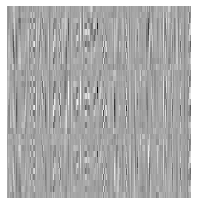

In [28]:
plot_weights(alexnet, 0, single_channel = True, collated = True)

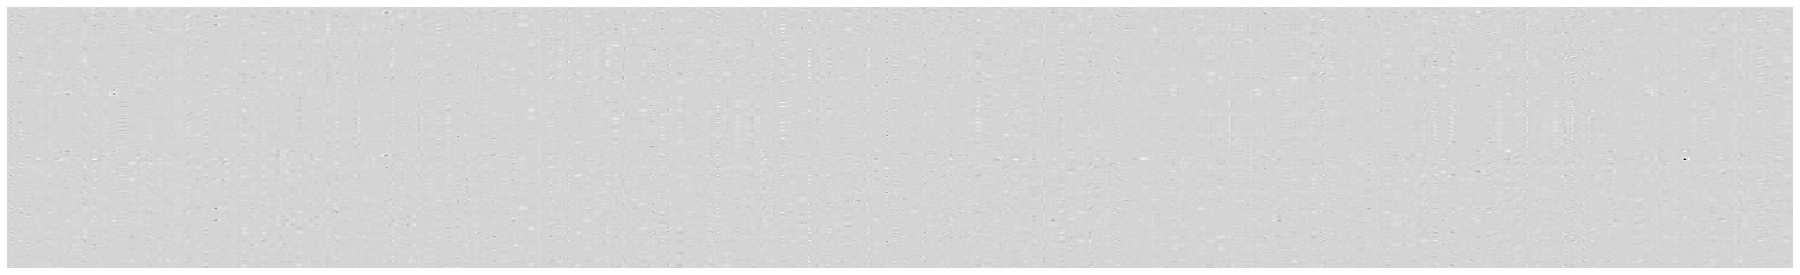

In [29]:
plot_weights(alexnet, 3, single_channel = True, collated = True)

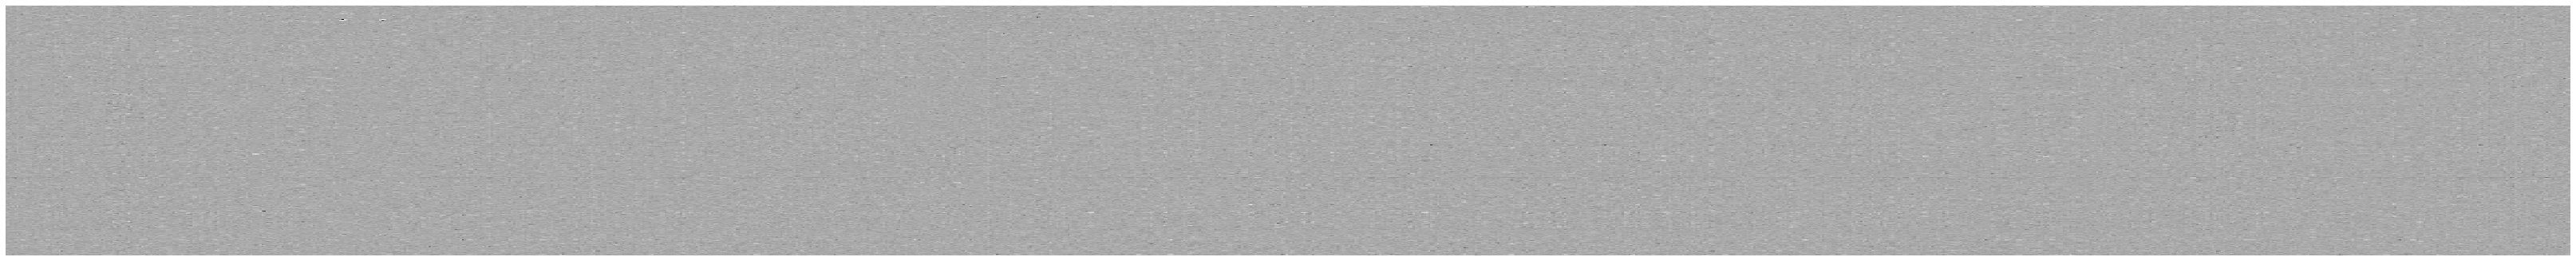

In [30]:
plot_weights(alexnet, 6, single_channel = True, collated = True)

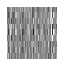

In [31]:
plot_weights(model, 0, single_channel = True, collated = True)

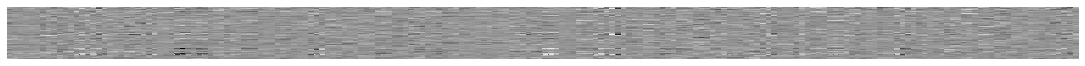

In [32]:
plot_weights(model, 2, single_channel = True, collated = True)

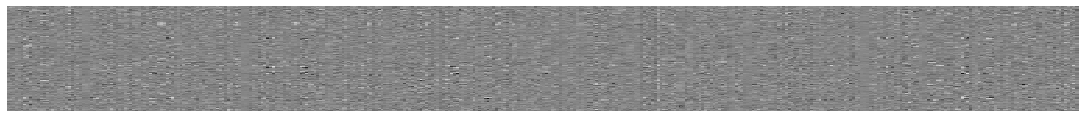

In [33]:
plot_weights(model, 5, single_channel = True, collated = True)